In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option('display.max_columns', 1000)

In [3]:
data = pd.read_parquet("../player_stats_2019.parquet")#player stats from rbdm github
cpoe_epa = pd.read_csv("../2008-2018QB_cpoe_epa.csv")#epa/cpoe from rbdm site 

In [4]:
#selecting for just quarterbacks and the columns name, team and week 
qb_data = data[data['passing_yards'] > 50][['player_name', 'recent_team', 'week']]

In [5]:
#selecting for just name and EPA + cpoe
trim_qb_epa = cpoe_epa[['Player', 'EPA+CPOE composite']]

In [6]:
#renaming columns
trim_qb_epa.rename(columns= {'Player':'player_name','EPA+CPOE composite':'epa+cpoe'}, inplace= True)

/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [7]:
#rectifying a discrepancy where one dataset had player name in a different format 
trim_qb_epa.player_name = trim_qb_epa.player_name.astype('str')
qb_data.player_name = qb_data.player_name.astype('str')


/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
#merging week by week qb data with epa/cpoe data 
cpoe_epa_weekly_data = trim_qb_epa.merge(qb_data)

In [62]:
cpoe_epa_weekly_data.recent_team.unique()

array(['KC', 'NO', 'GB', 'NE', 'LAC', 'SF', 'SEA', 'HOU', 'PIT', 'ATL',
       'TB', 'DAL', 'MIN', 'PHI', 'TEN', 'CLE', 'CIN', 'LA', 'CAR', 'NYG',
       'BAL', 'DET', 'CHI', 'DEN', 'MIA', 'JAX', 'BUF', 'LV', 'WAS',
       'IND', 'NYJ'], dtype=object)

In [122]:
betting_data = pd.read_csv('../nfl_data/spreadspoke_scores.csv')#betting data from kaggle 

In [123]:
betting_data = betting_data[betting_data.schedule_playoff == False]

In [124]:
#selecting the spread, which team was favored, week, home/away team, home/ away score
#only from the 2021 season 
betting_data = betting_data[betting_data.schedule_season == 2019][['spread_favorite','team_favorite_id','schedule_week',
                                                                   'team_home', 'team_away', 'score_away', 'score_home']]

In [125]:
#resetting the index of this smaller dataframe 
betting_data.reset_index(inplace= True)

In [126]:
#dropping the old index 
betting_data.drop('index', axis = 1,inplace= True)

In [127]:
#importing ID data to make the team names the same format as my other data
id_data = pd.read_csv('../nfl_teams.csv')

In [128]:
#simplyfing to only the needed columns 
id_data = id_data[['Name', 'Abbreviation']]

In [129]:
id_data

,Name,Abbreviation
0,Arizona Cardinals,ARI
1,Atlanta Falcons,ATL
2,Baltimore Ravens,BAL
3,Buffalo Bills,BUF
4,Carolina Panthers,CAR
5,Chicago Bears,CHI
6,Cincinnati Bengals,CIN
7,Cleveland Browns,CLE
8,Dallas Cowboys,DAL
9,Denver Broncos,DEN


In [130]:
#changing "New York" to 'NY'
id_data['Name'] = id_data.Name.replace(['NY Giants', 'NY Jets', 'Las Vegas Raiders', 'Washington Football Team'], ['New York Giants', 'New York Jets', 'Oakland Raiders', 'Washington Redskins'])

In [131]:
#makinga function to fetch the name from one the names data set and update the betting data dataset 
def change_to_abrev(name):
    return id_data[id_data.Name == name]['Abbreviation'].values[0]

    

In [132]:
betting_data.team_home.unique()

array(['Chicago Bears', 'Arizona Cardinals', 'Carolina Panthers',
       'Cleveland Browns', 'Dallas Cowboys', 'Jacksonville Jaguars',
       'Los Angeles Chargers', 'Miami Dolphins', 'Minnesota Vikings',
       'New England Patriots', 'New York Jets', 'Philadelphia Eagles',
       'Seattle Seahawks', 'Tampa Bay Buccaneers', 'New Orleans Saints',
       'Oakland Raiders', 'Atlanta Falcons', 'Baltimore Ravens',
       'Cincinnati Bengals', 'Denver Broncos', 'Detroit Lions',
       'Green Bay Packers', 'Houston Texans', 'Los Angeles Rams',
       'New York Giants', 'Pittsburgh Steelers', 'Tennessee Titans',
       'Washington Redskins', 'Buffalo Bills', 'Indianapolis Colts',
       'Kansas City Chiefs', 'San Francisco 49ers'], dtype=object)

In [133]:
#implementing the function
betting_data.team_away = betting_data['team_away'].apply(lambda x: change_to_abrev(x))


In [134]:
betting_data.team_home = betting_data['team_home'].apply(lambda x: change_to_abrev(x))

In [135]:
#adding a variable that checks whether the home team won 
betting_data['home_win'] = betting_data['score_home'] > betting_data['score_away']

In [136]:
#making a simple function to check if the home team was the favorite
def home_favorite(x, y):
    return x == y

In [137]:
#implementing the function in a new column 
betting_data['home_favorite'] = betting_data.apply(lambda x: home_favorite(x['team_home'], x['team_favorite_id']), axis =1)

In [138]:
#adding a margin of victory column to the data 
betting_data['mov'] = abs(betting_data['score_away'] - betting_data['score_home'])

In [139]:
#creating a function to see which team covered 
def cover (spread, home_win, home_favorite, mov, home, away):
    if (home_win) & (home_favorite) & (mov>abs(spread)):
        return home
    elif (home_win) & (home_favorite) & (mov<abs(spread)):
        return away
    elif (home_win) & (home_favorite == False):
        return home
    elif (home_win == False)& (home_favorite):
        return away
    elif (home_win == False) & (home_favorite == False) & (mov>abs(spread)):
        return away 
    elif (home_win == False) & (home_favorite == False) & (mov<abs(spread)):
        return home

In [140]:
#implementing the cover function in a new column 
betting_data['cover'] = betting_data.apply(lambda row: cover(row['spread_favorite'], row['home_win'], row['home_favorite'], 
                                                             row['mov'], row['team_home'], row['team_away']), axis =1)

In [141]:
betting_data['schedule_week'] = betting_data.schedule_week.astype(int)

In [142]:
#creating a function to get the rating from the cpoe dataset
def qb_rating(team, week):
    results = cpoe_epa_weekly_data[(cpoe_epa_weekly_data.week == week)&(cpoe_epa_weekly_data.recent_team == team)]['epa+cpoe'].values
    if len(results) > 0:
        return results[0]
    else:
        return None
        

In [143]:
betting_data['home_qb'] = betting_data.apply(lambda row: qb_rating(row['team_home'], row['schedule_week']), axis = 1)

In [144]:
betting_data['away_qb'] = betting_data.apply(lambda row: qb_rating(row['team_away'], row['schedule_week']), axis = 1)

In [145]:
betting_data

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb
0,-3.0,CHI,1,CHI,GB,10,3,False,True,7,GB,0.070,0.152
1,-3.0,DET,1,ARI,DET,27,27,False,False,0,ARI,NaN,0.070
2,-2.0,LAR,1,CAR,LAR,30,27,False,False,3,LAR,0.081,NaN
3,-5.5,CLE,1,CLE,TEN,43,13,False,True,30,TEN,0.089,0.093
4,-7.0,DAL,1,DAL,NYG,17,35,True,True,18,DAL,0.104,0.079
5,-3.5,KC,1,JAX,KC,40,26,False,False,14,KC,0.062,0.202
6,-6.0,LAC,1,LAC,IND,24,30,True,True,6,None,0.145,0.011
7,-7.0,BAL,1,MIA,BAL,59,10,False,False,49,BAL,0.066,0.032
8,-3.5,MIN,1,MIN,ATL,12,28,True,True,16,MIN,0.100,0.130
9,-5.5,NE,1,NE,PIT,3,33,True,True,30,NE,0.149,0.132


In [146]:
condensed = betting_data.dropna()

In [147]:
condensed.head()

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb
0,-3.0,CHI,1,CHI,GB,10,3,False,True,7,GB,0.070,0.152
3,-5.5,CLE,1,CLE,TEN,43,13,False,True,30,TEN,0.089,0.093
4,-7.0,DAL,1,DAL,NYG,17,35,True,True,18,DAL,0.104,0.079
5,-3.5,KC,1,JAX,KC,40,26,False,False,14,KC,0.062,0.202
7,-7.0,BAL,1,MIA,BAL,59,10,False,False,49,BAL,0.066,0.032


In [148]:
def qb_getting_points (home_qb, away_qb, home_favorite):
    if (home_qb < away_qb) & (home_favorite):
        return True
    if (home_qb> away_qb)&(home_favorite == False):
        return True 
    else:
        return False 

In [149]:
condensed['qb_getting_points'] = condensed.apply(lambda row: qb_getting_points(row['home_qb'], row['away_qb'], row['home_favorite']), axis = 1)

/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [150]:
condensed[condensed.qb_getting_points == True]

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb,qb_getting_points
0,-3.0,CHI,1,CHI,GB,10,3,False,True,7,GB,0.070,0.152,True
3,-5.5,CLE,1,CLE,TEN,43,13,False,True,30,TEN,0.089,0.093,True
7,-7.0,BAL,1,MIA,BAL,59,10,False,False,49,BAL,0.066,0.032,True
8,-3.5,MIN,1,MIN,ATL,12,28,True,True,16,MIN,0.100,0.130,True
13,-1.0,TB,1,TB,SF,31,17,False,True,14,SF,0.109,0.143,True
16,-6.5,CAR,2,CAR,TB,20,14,False,True,6,TB,0.081,0.109,True
17,-1.0,PHI,2,ATL,PHI,20,24,True,False,4,ATL,0.130,0.100,True
19,-1.0,CIN,2,CIN,SF,41,17,False,True,24,SF,0.086,0.143,True
26,-1.0,BUF,2,NYG,BUF,28,14,False,False,14,BUF,0.079,0.012,True
28,-4.0,PIT,2,PIT,SEA,28,26,False,True,2,SEA,0.132,0.141,True


In [151]:
#if cover == home qb and home qb > away qb 
#if cover == away and and away > homeqb

In [152]:
def did_they_cover(cover, home_team, away_team, home_qb, away_qb):
    if (home_qb > away_qb) & (cover == home_team):
        return True
    if (away_qb > home_qb) & (cover == away_team):
        return True
    else:
        return False

In [153]:
condensed['did_they_cover'] = condensed.apply(lambda row: did_they_cover(row['cover'], row['team_home'], row['team_away'], row['home_qb'], row['away_qb']), axis = 1)

/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [154]:
condensed_only_getpt = condensed[condensed.qb_getting_points == True]

In [165]:
condensed_only_getpt.groupby('did_they_cover').count()

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb,qb_getting_points
did_they_cover,,,,,,,,,,,,,,
False,16,16,16,16,16,16,16,16,16,16,16,16,16,16
True,27,27,27,27,27,27,27,27,27,27,27,27,27,27


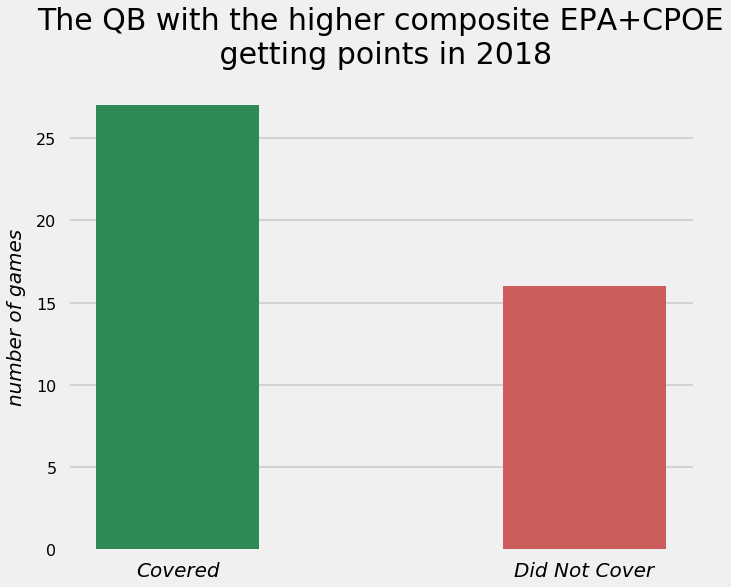

In [189]:
plt.style.use(['fivethirtyeight']) #making my graphs look purd..ier
plt.style.use(['seaborn-poster'])
plt.figure(figsize = (10, 8))#figsize
colors = ('seagreen', 'indianred')#custom color palletes 
# using the value counts queries and labels in an easier to manipulate(for me) list 
outcome = ['Covered', 'Did Not Cover']
count = [27, 16]
plt.bar(outcome, count, color= colors, width =.4)#plotting
plt.title('The QB with the higher composite EPA+CPOE\n getting points in 2018', size = 30, pad = 20, loc = 'center')#title
#style tweaks
plt.ylabel("number of games", size = 20, labelpad = 10, style = 'italic')
plt.xticks(style = 'italic', size = 20)
plt.grid(axis = 'x')


In [157]:
len(condensed_only_getpt)

43

In [160]:
condensed.groupby("did_they_cover").count()/len(condensed)

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb,qb_getting_points
did_they_cover,,,,,,,,,,,,,,
False,0.482759,0.482759,0.482759,0.482759,0.482759,0.482759,0.482759,0.482759,0.482759,0.482759,0.482759,0.482759,0.482759,0.482759
True,0.517241,0.517241,0.517241,0.517241,0.517241,0.517241,0.517241,0.517241,0.517241,0.517241,0.517241,0.517241,0.517241,0.517241


In [191]:
condensed.to_csv("better_qb_2019.csv", index = False)